In [2]:
import seaborn as sns
sns.set_style("whitegrid")
from process_model import *
from fit_process import *
from chase.cpt import w_prelec

from scipy.stats import norm
from scipy.stats.mstats import mquantiles
    

#from chase.base import *
#from chase.utils import *
#from chase.fit import *

import pickle

PARS = {'theta': [0, 100, 3],
        'p_stay': [0, 1, .1],
        'p_fixed': [0, 1, .1],
        'p_stop_geom': [0, 1, .5],
        'tau': [.001, 50],
        'tau_unif': [0, 1],
        'prelec_gamma': [.01, 3],
        'prelec_elevation': [.01, 3],
        'prelec_gamma_loss': [.01, 3],
        'prelec_elevation_loss': [.01, 3],
        'pow_gain': [0., 5],
        'w_loss': [0., 10],
        'phi': [0, 100]}



def expected_value(options):
    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    return np.sum(v, 1)


def evar(options):

    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    # expected variance of each option
    evar = np.array([np.dot(weights[i], values[i] ** 2) - np.sum(v[i]) ** 2 for i in range(len(options))])

    return evar

def max_ev(options):
    ev = expected_value(options)
    if ev[0] > ev[1]:
        return [1, 0]
    else:
        return [0, 1]


def max_var(options):
    v = evar(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def cv(options):
    ev = expected_value(options)
    sd = np.sqrt(evar(options))    
    return sd / ev


def max_cv(options):
    v = cv(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def pfix(p):
    c = 1e-5
    return np.min([np.max([p, c]), 1 - c])


P_STOP_GEOM = {'HBWE': .053418,
               'HPKH1': 0.07666,
               'HPKH2': 0.02627}

P_SWITCH = {'HBWE': .25,
            'HPKH1': .185,
            'HPKH2': .11}

bf_par = {}

cp = {}
bf_cp = {}

quant = {}
bf_quant = {}

N_ITER = 1

problems_str = {0: '4 w/ .8\nvs. 3',
                1: '4 w/ .2\nvs. 3 w/ .25',
                2: '-3 vs.\n-32 w/ .1',
                3: '-3 vs.\n-4 w/ .8',
                4: '32 w/ .1\nvs. 3',
                5: '32 w/ .025\nvs3 w/ .25'}

In [215]:
#FIGDEST = '/Users/markant/code/chase_paper/figures'
FIGDEST = '/Users/markant/Dropbox/Apps/ShareLaTeX/CHASE Paper/figures'

In [3]:
problems = {}
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
for i in range(len(arr)):
    problems[i] = arr[i].reshape((2,2,2))

In [ ]:
#coding = max_cv(problems[0])

In [13]:
trialdata_ungemach09 = pd.read_csv('paper/data/ungemach09/Ungemach09_sampling_134.0.txt', index_col=0, sep=" ")

In [22]:
choicedata_ungemach09 = pd.read_csv('paper/data/ungemach09/Ungemach09_choice_134.0.txt', index_col=0, sep=" ")

In [45]:
# problem 1
#   0: 4 w/ .8
#   1: 3 w/ 1

# problem 2
#   0: 4 w/ .2
#   1: 3 w/ .25

# problem 3
#   0: -3 w/ 1
#   1: -32 w/ .1

# problem 4
#   0: -3 w/ 1
#   1: -4 w/ .8

# problem 5
#   0: 32 w/ .1
#   1: 3 w/ 1

# problem 6
#   0: 32 w/ .025
#   1: 3 w/ .25

array([[[  3.00000000e+00,   2.50000000e-01],
        [  0.00000000e+00,   7.50000000e-01]],

       [[  3.20000000e+01,   2.50000000e-02],
        [  0.00000000e+00,   9.75000000e-01]]])

In [20]:
data_ungemach09 = trialdata_ungemach09.groupby(['subject', 'problem']).apply(lambda d: pd.Series({'samplesize': d.shape[0]})).reset_index()

In [56]:
data_ungemach09['choice'] = choicedata_ungemach09.sort_values(by=['subject','problem']).choice.values

In [57]:
data_ungemach09.head()

,subject,problem,samplesize,choice
0,23,1,2,1
1,23,2,6,0
2,23,3,10,0
3,23,4,6,0
4,23,5,3,1


In [59]:
data_ungemach09['choice'] = np.abs(1-data_ungemach09['choice'].values)
data_ungemach09['problem'] = data_ungemach09['problem'] - 1

,subject,problem,samplesize,choice
0,23,0,2,1
1,23,1,6,0
2,23,2,10,0
3,23,3,6,0
4,23,4,3,1
5,23,5,8,1
6,29,0,20,0
7,29,1,22,0
8,29,2,42,0
9,29,3,15,0


In [8]:
data_hertwig04 = pd.read_csv('paper/data/hertwig2004/hertwig2004_data.csv', index_col=0).reset_index()

In [73]:
data_hau08 = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)

In [74]:
data_hau08 = data_hau08[data_hau08.group==1]

In [75]:
data_ungemach09['study'] = 'UCS09'
data_hertwig04['study'] = 'HBWE04'
data_hau08['study'] = 'HPKH08'

In [76]:
data = pd.concat((data_ungemach09, data_hertwig04, data_hau08))

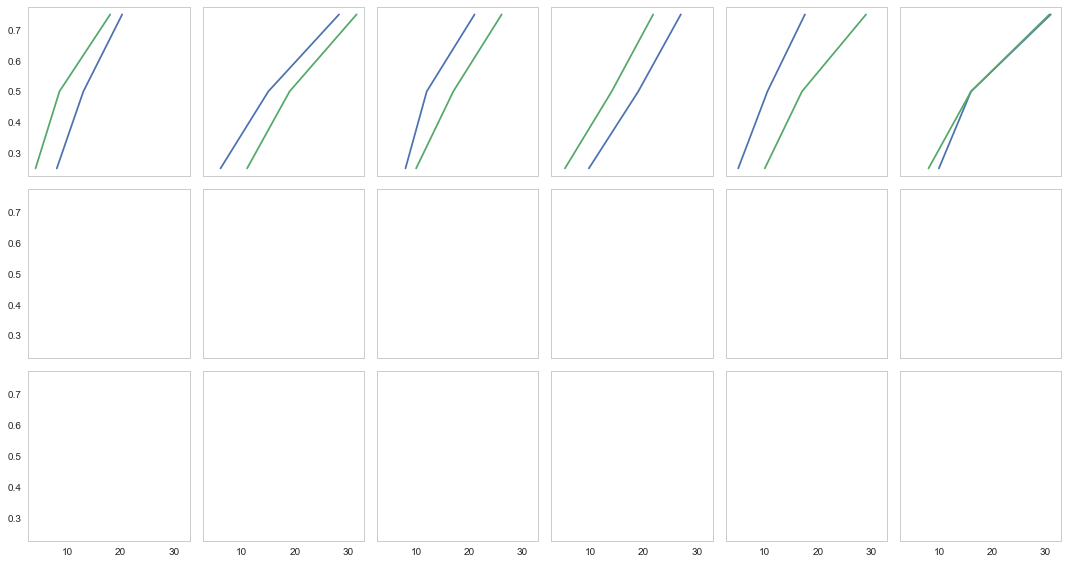

In [79]:
qs = [.25,.5,.75]
fig, ax = plt.subplots(3, 6, figsize=(15,8), sharex=True, sharey=True)

for pid in range(6):
    for group in range(3):
        axi = ax[group][pid]
        for choice in [0, 1]:
            axi.plot(mquantiles(data[(data.group==group) & (data.problem==pid) & (data.choice==choice)].samplesize), qs)
        axi.grid(None)
plt.tight_layout()
plt.show()

In [80]:
problems

{0: array([[[ 3. ,  1. ],
         [ 0. ,  0. ]],
 
        [[ 4. ,  0.8],
         [ 0. ,  0.2]]]), 1: array([[[ 3.  ,  0.25],
         [ 0.  ,  0.75]],
 
        [[ 4.  ,  0.2 ],
         [ 0.  ,  0.8 ]]]), 2: array([[[-32. ,   0.1],
         [  0. ,   0.9]],
 
        [[ -3. ,   1. ],
         [  0. ,   0. ]]]), 3: array([[[-4. ,  0.8],
         [ 0. ,  0.2]],
 
        [[-3. ,  1. ],
         [ 0. ,  0. ]]]), 4: array([[[  3. ,   1. ],
         [  0. ,   0. ]],
 
        [[ 32. ,   0.1],
         [  0. ,   0.9]]]), 5: array([[[  3.00000000e+00,   2.50000000e-01],
         [  0.00000000e+00,   7.50000000e-01]],
 
        [[  3.20000000e+01,   2.50000000e-02],
         [  0.00000000e+00,   9.75000000e-01]]])}

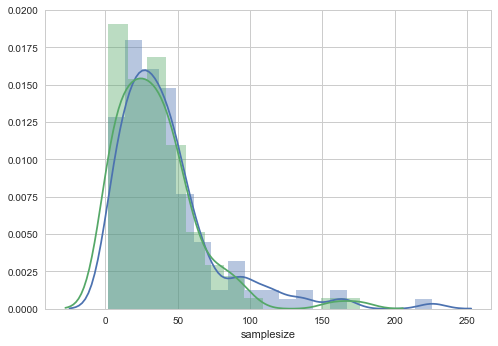

In [227]:
sns.distplot(data[(data.group==2) & (data.choice==0)].samplesize)
sns.distplot(data[(data.group==2) & (data.choice==1)].samplesize)

# Fit combined data

In [78]:
data.group = 0

In [81]:
allresults = []

PARSETS = {}
PARSETS['optional'] = [#['theta', 'tau', 'c_sigma'],
                       #['theta', 'tau', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                       #['theta', 'tau', 'c_sigma', 'pow_gain', 'w_loss'],
                       ['theta', 'tau_trunc', 'c_sigma'],
                       ['theta', 'tau_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                       #['theta', 'tau_trunc', 'c_sigma', 'c_0'],
                       #['theta', 'tau_normal_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                       #['theta', 'tau_trunc', 'c_sigma', 'pow_gain', 'w_loss'],
                       #
                       #['theta', 'tau_rel_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                       #['theta', 'tau_rel_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma', 'sc'],
                       #['theta', 'tau', 'c_sigma', 'prelec_elevation', 'prelec_gamma', 'sc2'],
                       #['theta', 'tau', 'c_sigma', 'c_0'],
                       #['theta', 'tau', 'c_sigma', 'c_0', 'prelec_elevation', 'prelec_gamma'],
                       #['theta', 'tau', 'c_sigma', 'c_0', 'pow_gain', 'w_loss'],
                       #['theta', 'tau', 'c_sigma', 'c'],
                       #['theta', 'tau', 'c_sigma', 'c', 'prelec_elevation', 'prelec_gamma'],
                       #['theta', 'tau', 'c_sigma', 'c', 'pow_gain', 'w_loss'],
                       ]

PARSETS['geometric'] = [['p_stop_geom', 'tau', 'c_sigma'],
                        ['p_stop_geom', 'tau', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                        #['p_stop_geom', 'tau', 'c_sigma', 'pow_gain', 'w_loss'],
                        #['p_stop_geom', 'tau', 'c_sigma', 'c_0'],
                        #['p_stop_geom', 'tau', 'c_sigma', 'c_0', 'prelec_elevation', 'prelec_gamma'],
                        #['p_stop_geom', 'tau', 'c_sigma', 'c_0', 'pow_gain', 'w_loss'],
                        #['p_stop_geom', 'tau', 'c_sigma', 'c'],
                        #['p_stop_geom', 'tau', 'c_sigma', 'c', 'prelec_elevation', 'prelec_gamma'],
                        #['p_stop_geom', 'tau', 'c_sigma', 'c', 'pow_gain', 'w_loss'],
                        ]

N_ITER = 1

In [82]:
#for stoprule in ['optional', 'geometric']:
for stoprule in ['optional']:
    
    if stoprule == 'optional':
        SIM_ID = 'process_chapter'
        OUTDIR = 'process_fitresults_chapter'
        m = CHASEProcessModel(problems=problems,
                              stoprule='optional')
        
    elif stoprule == 'geometric':
        SIM_ID = 'process_planned_chapter'
        OUTDIR = 'process_planned_fitresults_chapter'
        m = CHASEProcessModel(problems=problems,
                              stoprule='fixedGeom')

    FIXED = {'minsamplesize': 2, 
             'max_T': 1000, 
             'N': 20000, 
             'stoprule': stoprule}

    for fitting in PARSETS[stoprule]:
        results = fit_mlh(m, problems, data, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR,
                          method='DE')

c_sigma	tau_trunc	theta
differential_evolution step 1: f(x)= 2399.43
differential_evolution step 2: f(x)= 2399.43
differential_evolution step 3: f(x)= 2396.83
differential_evolution step 4: f(x)= 2396.83
differential_evolution step 5: f(x)= 2396.83
differential_evolution step 6: f(x)= 2396.42
process_chapter(c_sigma,tau_trunc,theta|N=20000,max_T=1000,minsamplesize=2,stoprule=optional)
0/1
iteration          0
success         True
nllh         2396.42
k                  3
N                530
bic          4811.66
c_sigma      34.7434
tau_trunc    60.7654
theta        137.571
Name: 0, dtype: object
process_fitresults_chapter/process_chapter(c_sigma,tau_trunc,theta|N=20000,max_T=1000,minsamplesize=2,stoprule=optional).csv
c_sigma	prelec_elevation	prelec_gamma	tau_trunc	theta
differential_evolution step 1: f(x)= 2392.33
differential_evolution step 2: f(x)= 2392.33
differential_evolution step 3: f(x)= 2392.33


KeyboardInterrupt: 

In [7]:
results = pd.DataFrame([], columns=['model', 'sim_id', 'dataset', 'stoprule', 'k', 'N', 'nllh', 'bic', 
                                    'tau', 'tau_trunc', 'tau_unif',
                                    'theta', 'p_stop_geom', 'sc', 'sc2', 'sc0', 'c', 'c_sigma', 'c_0', 
                                    'pow_gain', 'w_loss', 'prelec_elevation', 'prelec_gamma'])
    
for stoprule in ['optional', 'geometric']:
    
    if stoprule == 'optional':
        SIM_ID = 'process_hertwig2004'
        OUTDIR = 'process_fitresults_hertwig2004'
    elif stoprule == 'geometric':
        SIM_ID = 'process_planned_hertwig2004'
        OUTDIR = 'process_planned_fitresults_hertwig2004'
    FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': stoprule}

    for i, parset in enumerate(PARSETS[stoprule]):
        b = best_result(SIM_ID, FIXED, parset, outdir=OUTDIR)
        if b is not None:
            b['model'] = i
            b['dataset'] = 'HBWE04'
            b['stoprule'] = stoprule
            results.loc[results.shape[0]] = b
                
results['pars'] = results['sim_id'].apply(lambda d: d.split('|')[0].split('(', 1)[1])
allresults.append(results)
results.sort_values('bic')

,model,sim_id,dataset,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_unif,theta,p_stop_geom,sc,sc2,sc0,c,c_sigma,c_0,pow_gain,w_loss,prelec_elevation,prelec_gamma,pars
1,1,"process_hertwig2004(c_sigma,prelec_elevation,p...",HBWE04,optional,5,150,677.742123,1380.537423,NaN,44.593914,NaN,74.911995,NaN,NaN,NaN,NaN,NaN,17.219885,NaN,NaN,NaN,0.411553,2.729370,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
2,2,"process_hertwig2004(c_sigma,prelec_elevation,p...",HBWE04,optional,5,150,678.373003,1381.799183,NaN,NaN,NaN,79.473859,NaN,NaN,NaN,NaN,NaN,18.518928,NaN,NaN,NaN,0.611534,2.798057,"c_sigma,prelec_elevation,prelec_gamma,tau_norm..."
0,0,"process_hertwig2004(c_sigma,tau_trunc,theta|N=...",HBWE04,optional,3,150,692.247154,1399.526214,NaN,58.732375,NaN,103.006831,NaN,NaN,NaN,NaN,NaN,23.631165,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau_trunc,theta"
3,0,"process_planned_hertwig2004(c_sigma,p_stop_geo...",HBWE04,geometric,3,150,693.575166,1402.182239,27.104862,NaN,NaN,NaN,0.050954,NaN,NaN,NaN,NaN,0.386313,NaN,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom,tau"
4,1,"process_planned_hertwig2004(c_sigma,p_stop_geo...",HBWE04,geometric,5,150,688.565710,1402.184596,18.528572,NaN,NaN,NaN,0.055850,NaN,NaN,NaN,NaN,24.186548,NaN,NaN,NaN,1.229152,1.641948,"c_sigma,p_stop_geom,prelec_elevation,prelec_ga..."


In [9]:
fitting = PARSETS['optional'][1]
SIM_ID = 'process_hertwig2004'
OUTDIR = 'process_fitresults_hertwig2004'
m = CHASEProcessModel(problems=problems,
                      stoprule='optional')
FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': 'optional'}

best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, data, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)
print best

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          677.742
k                                                                   5
N                                                                 150
bic                                                           1380.54
c_sigma                                                       17.2199
prelec_elevation                                             0.411553
prelec_gamma                                                  2.72937
tau_trunc                                                     44.5939
theta                                                          74.912
sim_id              process_hertwig2004(c_sigma,prelec_elevation,p...
Name: 0, dtype: obje

In [10]:
bf_par[SIM_ID] = best

cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = pred.groupby('problem').apply(lambda d: np.mean(d.pred_cp))

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].mean().values

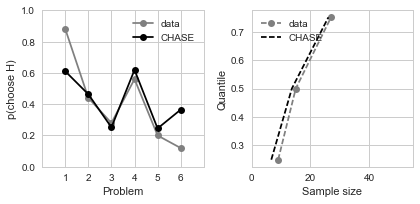

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

In [26]:
bf_cp['process_hertwig2004']

problem
0    0.610
1    0.463
2    0.252
3    0.619
4    0.245
5    0.365
dtype: float64

In [40]:
pset = [0, 4, 3, 2]
np.mean([bf_cp['process_hertwig2004'][0], 
         bf_cp['process_hertwig2004'][4], 
         1 - bf_cp['process_hertwig2004'][3],
         1 - bf_cp['process_hertwig2004'][4]])

0.49774999999999997

In [42]:
data.groupby('problem').apply(lambda d: d.shape)

problem
0    (25, 6)
1    (25, 6)
2    (25, 6)
3    (25, 6)
4    (25, 6)
5    (25, 6)
dtype: object

In [23]:
pred.groupby('problem').apply(lambda d: np.mean(d['pred_ss(.5)']))

problem
0    14.0
1    14.0
2    13.0
3    14.0
4    13.0
5    14.0
dtype: float64

In [24]:
pred.groupby('problem').apply(lambda d: np.mean(d['pred_ss(.5)'])).mean()

13.666666666666666

In [29]:
for pid in problems:
    print pid
    print problems[pid]
    print

0
[[[ 3.   1. ]
  [ 0.   0. ]]

 [[ 4.   0.8]
  [ 0.   0.2]]]

1
[[[ 3.    0.25]
  [ 0.    0.75]]

 [[ 4.    0.2 ]
  [ 0.    0.8 ]]]

2
[[[-32.    0.1]
  [  0.    0.9]]

 [[ -3.    1. ]
  [  0.    0. ]]]

3
[[[-4.   0.8]
  [ 0.   0.2]]

 [[-3.   1. ]
  [ 0.   0. ]]]

4
[[[  3.    1. ]
  [  0.    0. ]]

 [[ 32.    0.1]
  [  0.    0.9]]]

5
[[[  3.00000000e+00   2.50000000e-01]
  [  0.00000000e+00   7.50000000e-01]]

 [[  3.20000000e+01   2.50000000e-02]
  [  0.00000000e+00   9.75000000e-01]]]



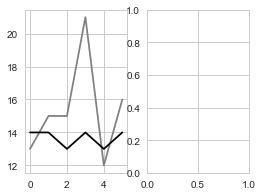

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(4,3))
ax[0].plot(data.groupby('problem').apply(lambda d: np.median(d.samplesize)), color='gray')
ax[0].plot(pred.groupby('problem').apply(lambda d: np.mean(d['pred_ss(.5)'])), color='black')
#ax[1].plot(data.groupby('problem').apply(lambda d: np.mean(d.samplesize)), color='gray')
#ax[1].plot(pred.groupby('problem').apply(lambda d: np.mean(d['ss(.5)'])), color='black')
plt.show()

# Hau et al 2008

In [359]:
SIM_ID = 'process_hau_exp1'
OUTDIR = 'process_fitresults_hau_exp1'
data = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==1]

In [360]:
#for stoprule in ['optional', 'geometric']:
for stoprule in ['optional']:
    
    if stoprule == 'optional':
        SIM_ID = 'process_hau_exp1'
        OUTDIR = 'process_fitresults_hau_exp1'
        m = CHASEProcessModel(problems=problems,
                              stoprule='optional')
        
    elif stoprule == 'geometric':
        SIM_ID = 'process_planned_hau_exp1'
        OUTDIR = 'process_planned_fitresults_hau_exp1'
        m = CHASEProcessModel(problems=problems,
                              stoprule='fixedGeom')

    FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 
             'stoprule': stoprule}


    
    for fitting in PARSETS[stoprule]:
        results = fit_mlh(m, problems, data, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR,
                          method='DE')

c_sigma	prelec_elevation	prelec_gamma	tau_normal_trunc	theta


process_model.py:265: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if switchfirst:
process_model.py:269: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  
process_model.py:310: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if self.problemtype is 'multinomial':
process_model.py:323: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sigmaB = np.sqrt(B[1])
process_model.py:354: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sum_A = np.cumsum(np.multiply(sampled_A, outcomes), axis=1)
process_model.py:477: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  crossed[indifferent] = np.random.c

differential_evolution step 1: f(x)= 952.686
differential_evolution step 2: f(x)= 950.454
differential_evolution step 3: f(x)= 949.048
differential_evolution step 4: f(x)= 949.048
differential_evolution step 5: f(x)= 949.048
differential_evolution step 6: f(x)= 947.197
differential_evolution step 7: f(x)= 947.197
differential_evolution step 8: f(x)= 946.322
differential_evolution step 9: f(x)= 946.196
process_hau_exp1(c_sigma,prelec_elevation,prelec_gamma,tau_normal_trunc,theta|N=20000,max_T=1000,minsamplesize=2,stoprule=optional)
0/1
iteration                 0
success                True
nllh                946.196
k                         5
N                       230
bic                 1919.58
c_sigma             11.3508
prelec_elevation    2.65049
prelec_gamma        1.55255
tau_normal_trunc    34.8476
theta               43.5185
Name: 0, dtype: object
process_fitresults_hau_exp1/process_hau_exp1(c_sigma,prelec_elevation,prelec_gamma,tau_normal_trunc,theta|N=20000,max_T=1000,min

In [325]:
results = pd.DataFrame([], columns=['model', 'sim_id', 'dataset', 'stoprule', 'k', 'N', 'nllh', 'bic', 
                                    'tau', 'tau_trunc', 'tau_unif',
                                    'theta', 'p_stop_geom', 'sc', 'sc2', 'c', 'c_sigma', 'c_0', 
                                    'pow_gain', 'w_loss', 'prelec_elevation', 'prelec_gamma'])
    
for stoprule in ['optional', 'geometric']:
    
    if stoprule == 'optional':
        SIM_ID = 'process_hau_exp1'
        OUTDIR = 'process_fitresults_hau_exp1'
    elif stoprule == 'geometric':
        SIM_ID = 'process_planned_hau_exp1'
        OUTDIR = 'process_planned_fitresults_hau_exp1'
    FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': stoprule}

    for i, parset in enumerate(PARSETS[stoprule]):
        b = best_result(SIM_ID, FIXED, parset, outdir=OUTDIR)
        if b is not None:
            b['model'] = i
            b['dataset'] = 'HPKH08-1'
            b['stoprule'] = stoprule
            results.loc[results.shape[0]] = b
                
results['pars'] = results['sim_id'].apply(lambda d: d.split('|')[0].split('(', 1)[1])
allresults.append(results)
results.sort_values('bic')

,model,sim_id,dataset,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_unif,theta,p_stop_geom,sc,sc2,c,c_sigma,c_0,pow_gain,w_loss,prelec_elevation,prelec_gamma,pars
3,3,"process_hau_exp1(c_sigma,prelec_elevation,prel...",HPKH08-1,optional,5,230,944.404552,1915.999501,NaN,55.895391,NaN,41.787590,NaN,NaN,NaN,NaN,11.200603,NaN,NaN,NaN,2.017759,0.976579,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
1,1,"process_hau_exp1(c_sigma,prelec_elevation,prel...",HPKH08-1,optional,5,230,947.679519,1922.549435,20.337216,NaN,NaN,57.162818,NaN,NaN,NaN,NaN,16.864626,NaN,NaN,NaN,2.875481,1.872761,"c_sigma,prelec_elevation,prelec_gamma,tau,theta"
5,1,"process_planned_hau_exp1(c_sigma,p_stop_geom,p...",HPKH08-1,geometric,5,230,950.633800,1928.457996,4.761463,NaN,NaN,NaN,0.074292,NaN,NaN,NaN,9.462516,NaN,NaN,NaN,2.091710,1.480037,"c_sigma,p_stop_geom,prelec_elevation,prelec_ga..."
4,0,"process_planned_hau_exp1(c_sigma,p_stop_geom,t...",HPKH08-1,geometric,3,230,966.875589,1950.065416,0.101789,NaN,NaN,NaN,0.076312,NaN,NaN,NaN,2.672525,NaN,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom,tau"
0,0,"process_hau_exp1(c_sigma,tau,theta|N=20000,max...",HPKH08-1,optional,3,230,968.211371,1952.736981,34.291038,NaN,NaN,93.252728,NaN,NaN,NaN,NaN,26.611845,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau,theta"
2,2,"process_hau_exp1(c_sigma,tau_trunc,theta|N=200...",HPKH08-1,optional,3,230,968.296945,1952.908127,NaN,67.868252,NaN,89.326196,NaN,NaN,NaN,NaN,24.709582,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau_trunc,theta"


In [361]:
fitting = PARSETS['optional'][0]
SIM_ID = 'process_hau_exp1'
OUTDIR = 'process_fitresults_hau_exp1'
m = CHASEProcessModel(problems=problems,
                      stoprule='optional')
FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': 'optional'}

best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, data, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)
print best
bf_par[SIM_ID] = best

cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = pred.groupby('problem').apply(lambda d: np.mean(d.pred_cp))

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].mean().values

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          946.196
k                                                                   5
N                                                                 230
bic                                                           1919.58
c_sigma                                                       11.3508
prelec_elevation                                              2.65049
prelec_gamma                                                  1.55255
tau_normal_trunc                                              34.8476
theta                                                         43.5185
sim_id              process_hau_exp1(c_sigma,prelec_elevation,prel...
Name: 0, dtype: obje

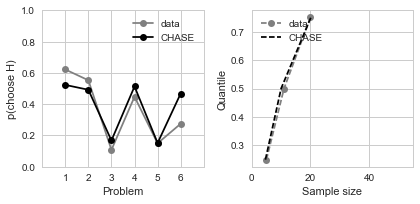

In [362]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

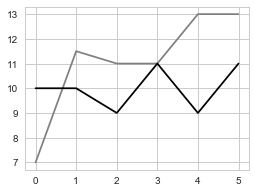

In [363]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(data.groupby('problem').apply(lambda d: np.median(d.samplesize)), color='gray')
ax.plot(pred.groupby('problem').apply(lambda d: np.mean(d['pred_ss(.5)'])), color='black')
plt.show()

In [364]:
SIM_ID = 'process_hau_exp2'
OUTDIR = 'process_fitresults_hau_exp2'
data = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==2]

In [366]:
#for stoprule in ['optional', 'geometric']:
for stoprule in ['optional']:
    
    if stoprule == 'optional':
        SIM_ID = 'process_hau_exp2'
        OUTDIR = 'process_fitresults_hau_exp2'
        m = CHASEProcessModel(problems=problems,
                              startdist='laplace',
                              stoprule='optional')
        
    elif stoprule == 'geometric':
        SIM_ID = 'process_planned_hau_exp2'
        OUTDIR = 'process_planned_fitresults_hau_exp2'
        m = CHASEProcessModel(problems=problems,
                              startdist='laplace',
                              stoprule='fixedGeom')

    FIXED = {'minsamplesize': 2, 
             'max_T': 1000, 
             'N': 20000, 
             'stoprule': stoprule}


    
    for fitting in PARSETS[stoprule]:
        results = fit_mlh(m, problems, data, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR,
                          method='DE')

c_sigma	prelec_elevation	prelec_gamma	tau_normal_trunc	theta


process_model.py:95: RuntimeWarning: invalid value encountered in divide
  omega = np.array(omega)
process_model.py:265: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if switchfirst:
process_model.py:269: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  
process_model.py:310: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if self.problemtype is 'multinomial':
process_model.py:323: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sigmaB = np.sqrt(B[1])
process_model.py:354: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sum_A = np.cumsum(np.multiply(sampled_A, outcomes), axis=1)
process_model.py:477: VisibleDeprecationWarning: using a non-integer numb

differential_evolution step 1: f(x)= 1263.42
differential_evolution step 2: f(x)= 1255
differential_evolution step 3: f(x)= 1247.09
differential_evolution step 4: f(x)= 1245.59
differential_evolution step 5: f(x)= 1245.59
differential_evolution step 6: f(x)= 1245.59
differential_evolution step 7: f(x)= 1245.59
differential_evolution step 8: f(x)= 1242.14
differential_evolution step 9: f(x)= 1242.14
differential_evolution step 10: f(x)= 1239.62
process_hau_exp2(c_sigma,prelec_elevation,prelec_gamma,tau_normal_trunc,theta|N=20000,max_T=1000,minsamplesize=2,stoprule=optional)
0/1
iteration                  0
success                 True
nllh                 1239.62
k                          5
N                        234
bic                  2506.53
c_sigma               20.658
prelec_elevation     1.30564
prelec_gamma        0.802803
tau_normal_trunc     52.0935
theta                129.693
Name: 0, dtype: object
process_fitresults_hau_exp2/process_hau_exp2(c_sigma,prelec_elevation,prel

In [329]:
results = pd.DataFrame([], columns=['model', 'sim_id', 'dataset', 'stoprule', 'k', 'N', 'nllh', 'bic', 
                                    'tau', 'tau_trunc', 'tau_unif',
                                    'theta', 'p_stop_geom', 'sc', 'sc2', 'c', 'c_sigma', 'c_0', 
                                    'pow_gain', 'w_loss', 'prelec_elevation', 'prelec_gamma'])
    
for stoprule in ['optional', 'geometric']:
    
    if stoprule == 'optional':
        SIM_ID = 'process_hau_exp2'
        OUTDIR = 'process_fitresults_hau_exp2'
    elif stoprule == 'geometric':
        SIM_ID = 'process_planned_hau_exp2'
        OUTDIR = 'process_planned_fitresults_hau_exp2'
    FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': stoprule}

    for i, parset in enumerate(PARSETS[stoprule]):
        b = best_result(SIM_ID, FIXED, parset, outdir=OUTDIR)
        if b is not None:
            b['model'] = i
            b['dataset'] = 'HPKH08-2'
            b['stoprule'] = stoprule
            results.loc[results.shape[0]] = b
                
results['pars'] = results['sim_id'].apply(lambda d: d.split('|')[0].split('(', 1)[1])
allresults.append(results)
results.sort_values(by='bic')

,model,sim_id,dataset,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_unif,theta,p_stop_geom,sc,sc2,c,c_sigma,c_0,pow_gain,w_loss,prelec_elevation,prelec_gamma,pars
0,0,"process_hau_exp2(c_sigma,tau,theta|N=20000,max...",HPKH08-2,optional,3,234,1238.290730,2492.947422,21.653684,NaN,NaN,84.735145,NaN,NaN,NaN,NaN,13.650023,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau,theta"
1,1,"process_hau_exp2(c_sigma,prelec_elevation,prel...",HPKH08-2,optional,5,234,1234.355750,2495.988106,28.257135,NaN,NaN,90.571916,NaN,NaN,NaN,NaN,14.325899,NaN,NaN,NaN,1.184572,0.883037,"c_sigma,prelec_elevation,prelec_gamma,tau,theta"
3,3,"process_hau_exp2(c_sigma,prelec_elevation,prel...",HPKH08-2,optional,5,234,1237.474017,2502.224639,NaN,58.792970,NaN,113.447407,NaN,NaN,NaN,NaN,17.964317,NaN,NaN,NaN,1.219588,1.023562,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
4,0,"process_planned_hau_exp2(c_sigma,p_stop_geom,t...",HPKH08-2,geometric,3,234,1242.965166,2502.296296,23.702089,NaN,NaN,NaN,0.026764,NaN,NaN,NaN,35.608116,NaN,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom,tau"
2,2,"process_hau_exp2(c_sigma,tau_trunc,theta|N=200...",HPKH08-2,optional,3,234,1244.177438,2504.720838,NaN,75.761853,NaN,122.759322,NaN,NaN,NaN,NaN,19.249887,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau_trunc,theta"
5,1,"process_planned_hau_exp2(c_sigma,p_stop_geom,p...",HPKH08-2,geometric,5,234,1239.229835,2505.736277,25.767102,NaN,NaN,NaN,0.025096,NaN,NaN,NaN,36.486894,NaN,NaN,NaN,1.633820,0.939720,"c_sigma,p_stop_geom,prelec_elevation,prelec_ga..."


In [330]:
fitting = PARSETS['optional'][3]
SIM_ID = 'process_hau_exp2'
OUTDIR = 'process_fitresults_hau_exp2'
m = CHASEProcessModel(problems=problems,
                      stoprule='optional')
FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': 'optional'}

best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, data, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)
print best
bf_par[SIM_ID] = best

cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = pred.groupby('problem').apply(lambda d: np.mean(d.pred_cp))

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].mean().values

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1237.47
k                                                                   5
N                                                                 234
bic                                                           2502.22
c_sigma                                                       17.9643
prelec_elevation                                              1.21959
prelec_gamma                                                  1.02356
tau_trunc                                                      58.793
theta                                                         113.447
sim_id              process_hau_exp2(c_sigma,prelec_elevation,prel...
Name: 0, dtype: obje

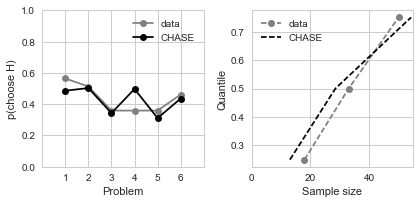

In [331]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

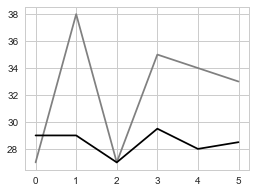

In [332]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(data.groupby('problem').apply(lambda d: np.median(d.samplesize)), color='gray')
ax.plot(pred.groupby('problem').apply(lambda d: np.mean(d['pred_ss(.5)'])), color='black')
plt.show()

# Combine results

In [333]:
combdf = pd.concat(allresults).sort_values(by=['dataset', 'stoprule', 'model'])

In [334]:
combdf.groupby(['stoprule', 'model']).agg({'bic': np.sum})

bic
stoprule  model             
geometric 0      5854.543950
          1      5836.378868
optional  0      5832.639189
          1      5802.671624
          2      5857.155179
          3      5798.761563

In [210]:
tab = combdf[['dataset', 'stoprule', 'model', 'N', 'k', 'nllh', 'bic', 'p_stop_geom', 'theta', 'tau', 'tau_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma']]
tab.to_csv('results_fits/sixproblems_allmodels.csv')
tab

,dataset,stoprule,model,N,k,nllh,bic,p_stop_geom,theta,tau,tau_trunc,c_sigma,prelec_elevation,prelec_gamma
4,HBWE04,geometric,0,150,3,693.575166,1402.182239,0.050954,NaN,27.104862,NaN,0.386313,NaN,NaN
5,HBWE04,geometric,1,150,5,688.565710,1402.184596,0.055850,NaN,18.528572,NaN,24.186548,1.229152,1.641948
0,HBWE04,optional,0,150,3,685.961440,1386.954785,NaN,28.328428,9.643363,NaN,5.915382,NaN,NaN
1,HBWE04,optional,1,150,5,679.540453,1384.134083,NaN,127.535891,33.893179,NaN,29.438528,0.960238,2.247556
2,HBWE04,optional,2,150,3,692.247154,1399.526214,NaN,103.006831,NaN,58.732375,23.631165,NaN,NaN
3,HBWE04,optional,3,150,5,677.742123,1380.537423,NaN,74.911995,NaN,44.593914,17.219885,0.411553,2.729370
4,HPKH08-1,geometric,0,230,3,966.875589,1950.065416,0.076312,NaN,0.101789,NaN,2.672525,NaN,NaN
5,HPKH08-1,geometric,1,230,5,950.633800,1928.457996,0.074292,NaN,4.761463,NaN,9.462516,2.091710,1.480037
0,HPKH08-1,optional,0,230,3,968.211371,1952.736981,NaN,93.252728,34.291038,NaN,26.611845,NaN,NaN
1,HPKH08-1,optional,1,230,5,947.679519,1922.549435,NaN,57.162818,20.337216,NaN,16.864626,2.875481,1.872761


In [211]:
bestmodel = tab[(tab.stoprule=='optional') & (tab.model==3)]
bestmodel.to_csv('results_fits/sixproblems_bestmodel.csv')
bestmodel

,dataset,stoprule,model,N,k,nllh,bic,p_stop_geom,theta,tau,tau_trunc,c_sigma,prelec_elevation,prelec_gamma
3,HBWE04,optional,3,150,5,677.742123,1380.537423,NaN,74.911995,NaN,44.593914,17.219885,0.411553,2.729370
3,HPKH08-1,optional,3,230,5,944.404552,1915.999501,NaN,41.787590,NaN,55.895391,11.200603,2.017759,0.976579
3,HPKH08-2,optional,3,234,5,1237.474017,2502.224639,NaN,113.447407,NaN,58.792970,17.964317,1.219588,1.023562


In [335]:
from mypy.viz import tableau20
labels = ['HBWE04', 'HPKH08, Exp 1', 'HPKH08, Exp 2']
studies = ['process_hertwig2004', 'process_hau_exp1', 'process_hau_exp2']

In [340]:
# derivative of weighting function
def w(p, delta, gamma):
    return (delta*gamma/p) * ((-np.log(p)) ** (gamma - 1)) * w_prelec(p, delta, gamma)

/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


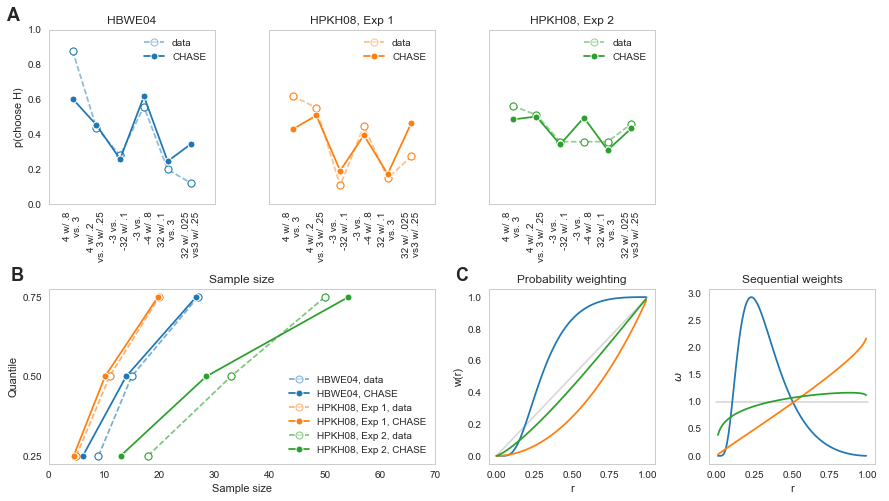

In [348]:
col = [tableau20[0], tableau20[2], tableau20[4]]

fig, ax = plt.subplots(2, 4, figsize=(12.5, 7), sharey=True)

ax[0][0].text(-.25, 1.05, 'A', fontsize=18, fontweight='semibold', transform=ax[0][0].transAxes)


for i, study in enumerate(studies):
    axi = ax[0][i]
    axi.plot(range(1, 7), cp[study], '--o', markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, color=col[i], alpha=.5,
             label='data')

    # hacky
    axi.plot(range(1, 7), cp[study], 'o', markerfacecolor='white', markeredgecolor=col[i],
             markeredgewidth=1)


    axi.plot(range(1, 7), bf_cp[study], '-o', markerfacecolor=col[i], markeredgecolor='white', 
             markeredgewidth=1, color=col[i], label='CHASE')
    axi.set_ylim(0, 1)
    axi.set_xlim(0, 7)
    axi.set_xticks(range(1,7))
    axi.set_xticklabels([problems_str[j] for j in range(6)], rotation=90)

    #axi.set_xlabel('Problem')
    
    axi.set_title(labels[i])
    axi.legend()
    axi.grid(None)

ax[0][0].set_ylabel('p(choose H)')

# sample size



axi = plt.subplot2grid((2,4), (1,0), colspan=2)
axi.text(-.1, 1.05, 'B', fontsize=18, fontweight='semibold', transform=axi.transAxes)

for i, study in enumerate(studies):

    axi.plot(quant[study], [.25, .5, .75], '--o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, label='%s, data' % labels[i], alpha=.6)
    
    # hacky
    axi.plot(quant[study], [.25, .5, .75], 'o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], markeredgewidth=1)

    axi.plot(bf_quant[study], [.25, .5, .75], '-o', color=col[i], 
             markerfacecolor=col[i], markeredgecolor='white',
             markeredgewidth=1, label='%s, CHASE' % labels[i])

axi.set_xlim(0, 70)
axi.legend(loc='lower right')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')
axi.set_yticks([.25, .5, .75])
axi.grid(None)
axi.set_title('Sample size')

# probability weighting

p = np.arange(0, 1, .01)

axi = plt.subplot2grid((2,4), (1,2))
axi.text(-.2, 1.05, 'C', fontsize=18, fontweight='semibold', transform=axi.transAxes)


axi.plot([0, 1], [0, 1], color='gray', alpha=.3)

for i, study in enumerate(studies):
    axi.plot(p, w_prelec(p, bf_par[study]['prelec_elevation'], bf_par[study]['prelec_gamma']), '-', 
             color=col[i], label=labels[i])

axi.set_title('Probability weighting')
axi.set_xlabel('r')
axi.set_ylabel('w(r)')
#axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axi.grid(None)


axi = plt.subplot2grid((2,4), (1,3))
#axi.text(-.2, 1.05, 'C', fontsize=18, fontweight='semibold', transform=axi.transAxes)
axi.plot([0, 1], [1, 1], color='gray', alpha=.3)

for i, study in enumerate(studies):
    axi.plot(p, w(p, bf_par[study]['prelec_elevation'], bf_par[study]['prelec_gamma']), '-', 
             color=col[i], label=labels[i])

axi.set_title('Sequential weights')
axi.set_xlabel('r')
axi.set_ylabel('$\omega$')
#axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axi.grid(None)


axi = plt.subplot2grid((2,4), (0,3))
axi.axis('off')


plt.tight_layout()
plt.show()
fig.savefig('%s/fitresults_6problems.pdf' % FIGDEST, bbox_inches='tight')

# Fitting combined data

In [76]:
data1 = pd.read_csv('paper/data/hertwig2004/hertwig2004_data.csv', index_col=0)
data2 = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)

In [79]:
data = pd.concat((data1, data2))

In [101]:
SIM_ID = 'process_hertwig2004+hau2008'
OUTDIR = 'process_fitresults_hertwig2004+hau2008'

FIXED = {'minsamplesize': 2, 'pref_units': 'sums', 'max_T': 1000, 'N': 20000}

PARSETS = [#['theta', 'tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ['theta(group=HBWE04)', 'theta(group=HPKH08-1)', 'theta(group=HPKH08-2)', 
            'tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ['theta', 
            'tau(group=HBWE04)', 'tau(group=HPKH08-1)', 'tau(group=HPKH08-2)',  
            'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ['theta', 'tau', 
            'pow_gain(group=HBWE04)', 'pow_gain(group=HPKH08-1)', 'pow_gain(group=HPKH08-2)', 
            'prelec_gamma', 'prelec_elevation'],
           ['theta', 'tau', 'pow_gain', 
            'prelec_gamma(group=HBWE04)', 'prelec_gamma(group=HPKH08-1)', 'prelec_gamma(group=HPKH08-2)', 
            'prelec_elevation'],
           ['theta', 'tau', 'pow_gain', 'prelec_gamma', 
            'prelec_elevation(group=HBWE04)', 'prelec_elevation(group=HPKH08-1)', 'prelec_elevation(group=HPKH08-2)'],
           ]

m = CHASEProcessModel(problems=problems,
                      startdist='laplace')

In [97]:
#data.loc[data.group==0,'group'] = 'HBWE04'
#data.loc[data.group==1,'group'] = 'HPKH08-1'
#data.loc[data.group==2,'group'] = 'HPKH08-2'

In [102]:
for pu in ['sums']:

    FIXED['pref_units'] = pu
    
    for fitting in PARSETS:

        #fitting = {p: PARS[p] for p in parset}
        results = fit_mlh(m, problems, data, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

pow_gain	prelec_elevation	prelec_gamma	tau	theta(group=HBWE04)	theta(group=HPKH08-1)	theta(group=HPKH08-2)
[  1.967   0.57    2.139  29.183  35.782   2.338  31.119] 4297.13235112
[  1.961   0.766   0.138  25.377  29.039  45.179  16.427] 3819.70130485
[  1.346   1.98    2.695  58.539  26.173  47.901  41.596] 4310.29050809
[  1.123   0.387   1.45   75.275   8.371  37.696  43.937] 3371.31893111
[  0.509   2.144   2.384  92.013   6.697   8.347  40.206] 4244.64083509
[  0.086   2.455   2.032  34.836  47.266   0.353   9.504] 4795.41688818
[  0.203   0.906   0.369  49.879  26.847  19.557   1.233] 4315.14197288
[  1.381   2.011   1.688  42.385  14.324   0.925  43.465] 4378.10847879
[  1.187   1.728   2.846  65.877  14.666   9.633  25.604] 4228.10555245
[  0.622   1.81    2.062   0.055  48.413   3.391   3.187] 5821.25017784
[  0.072   0.803   1.696  57.026  42.332  40.171  32.522] 4235.41112081
[  1.583   0.419   0.157  44.682  15.376  34.4    44.311] 3314.9365636
[  1.011   1.56    2.943  13.1

# Old

In [ ]:
HBWE_data = []

for i, grp in data.groupby(['subject', 'problem']):
    pid = grp.problem.values[0]
    
    ss = grp.shape[0]

    sampled_option = grp.option.values
    choice = grp.choice.values[-1]
    
    #coding = max_var(problems[pid])
    #sampled_option = np.array([coding[i] for i in grp.option.values])
    #choice = coding[grp.choice.values[-1]]
    
    if ss < cutoff:
        HBWE_data.append({'group': 0, 
                         'probid': pid,
                         'sampled_option': sampled_option,
                         'outcomes': grp.outcome.values,
                         'choice': choice,
                         'samplesize': ss})

### Baseline model

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel

N_ITER = 1
SIM_ID = 'process_baseline_HBWE04'
OUTDIR = 'process_baseline_fitresults_HBWE04'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [448]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,696.178344,1,150,1397.367324,0.053418


### Geom + two-stage

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel

N_ITER = 1
SIM_ID = 'process_2stage_HBWE04'
OUTDIR = 'process_2stage_fitresults_HBWE04'

FIXED = {'minsamplesize': 2,
         'p_stop_geom': .053418}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [451]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,664.271416,4,150,1348.585372,0.363671,0.31345,1.542747,2.729099


In [452]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_switch': .25,
            'p_stop_geom': .053418,
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

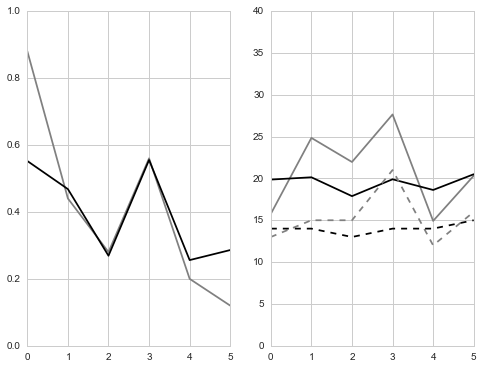

In [453]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE + geom

In [ ]:
SIM_ID = 'process_HBWE04'
OUTDIR = 'process_fitresults_HBWE04'
FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_stop_geom': .053418}
PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [455]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,716.13854,5,150,1457.330257,-0.000852,0.808129,0.995768,1.261691,0.643931


In [456]:
pred = {}
arr = []
for d in HBWE_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .053418,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

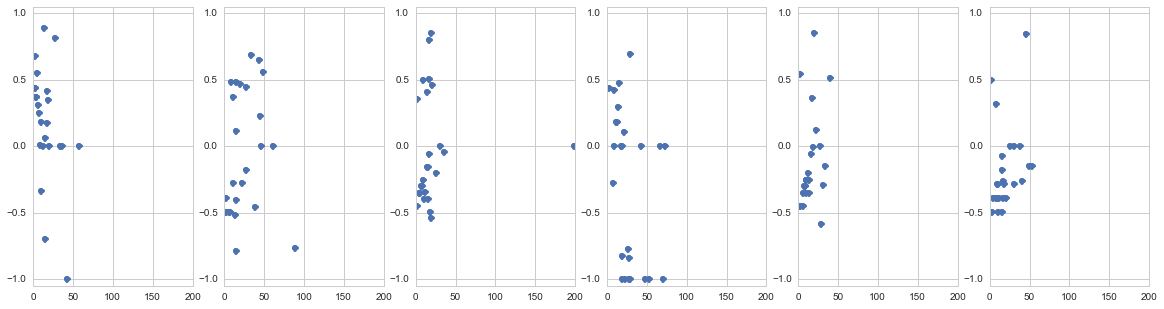

In [457]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,200)
plt.show()

In [461]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .053418,
            'p_switch': .25,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

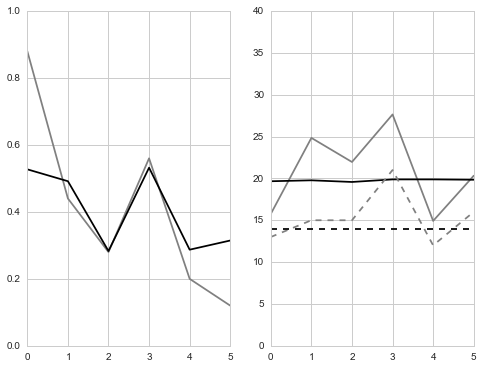

In [462]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE (optional stopping)

In [ ]:
N_ITER = 1
SIM_ID = 'process_hertwig2004'
OUTDIR = 'process_fitresults_hertwig2004'

FIXED = {'minsamplesize': 2,
         'p_switch': .25}
PARSETS = [['theta', 'tau', 'p_stay', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform')
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

In [428]:
results

,iteration,success,nllh,k,N,bic,p_stay,pow_gain,prelec_elevation,prelec_gamma,tau,theta
0,0,False,1305.835059,6,150,2641.73393,0.100995,0.561866,1.208618,1.073574,0.601972,2.784131


In [429]:
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
pred = {}
arr = []
for d in HBWE_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 0,
            'tau': results.loc[0]['tau'],
            'theta': results.loc[0]['theta'],
            'p_stay': results.loc[0]['p_stay'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

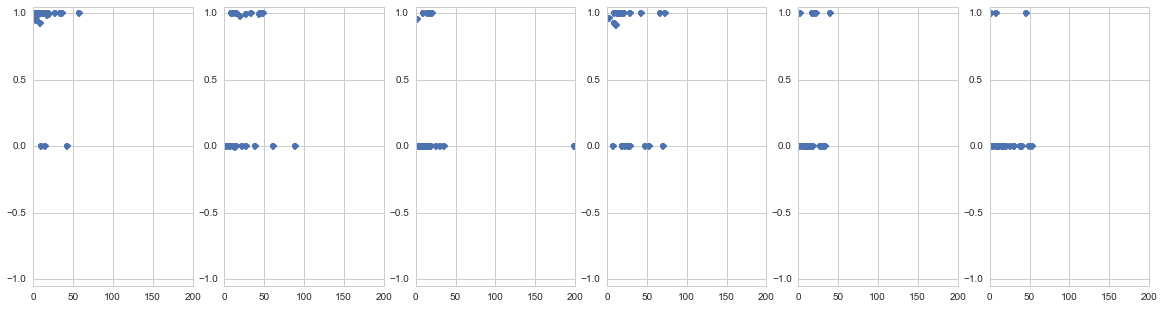

In [430]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,200)
plt.show()

In [432]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_switch': .25,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_stay': results.loc[0]['p_stay'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

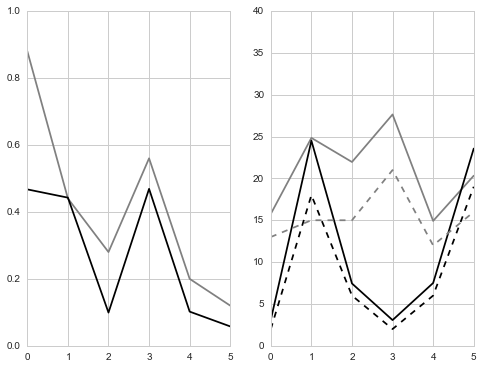

In [433]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

# Hau et al. (2008) - Experiment 1

In [ ]:
from mypy.explib.hau2008 import hau2008
HPKH1_data = hau2008.trial_data(study=1)

### Baseline

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel

N_ITER = 1
SIM_ID = 'process_baseline_HPKH1'
OUTDIR = 'process_baseline_fitresults_HPKH1'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [435]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,971.079115,1,230,1947.596308,0.07666


### Two-stage + geom

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel
N_ITER = 1
SIM_ID = 'process_2stage_HPKH1'
OUTDIR = 'process_2stage_fitresults_HPKH1'
FIXED = {'minsamplesize': 2,
         'p_stop_geom': .07666}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [437]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,902.001973,4,230,1825.756263,0.318952,0.60701,0.65675,4.775384


In [438]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

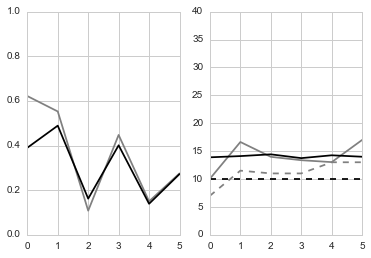

In [440]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE + geom

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH1'
OUTDIR = 'process_fitresults_HPKH1'

FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_switch': .185,
         'p_stop_geom': .07666}

PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [464]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,978.880092,5,230,1984.95058,0.000303,0.615612,1.175495,1.13464,0.540726


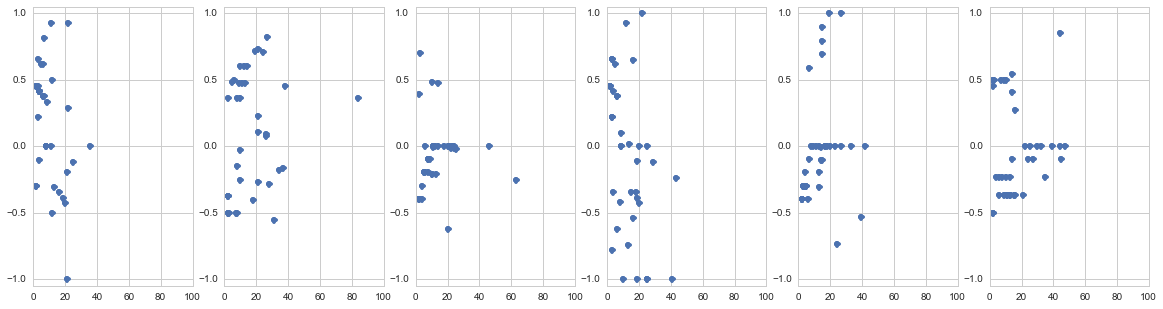

In [469]:
pred = {}
arr = []
for d in HPKH1_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,100)
plt.show()

In [470]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'p_switch': .185,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

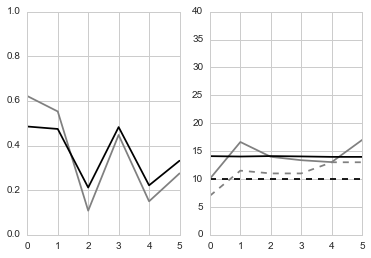

In [471]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE (optional)

In [446]:
N_ITER = 1
SIM_ID = 'process_HPKH1'
OUTDIR = 'process_fitresults_HPKH1'

FIXED = {'minsamplesize': 2,
         'p_switch': .185}
PARSETS = [['theta', 'tau', 'p_stay', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform')
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

p_stay	pow_gain	prelec_elevation	prelec_gamma	tau	theta
[ 0.1  1.   1.   1.   0.5  3. ] 2218.26060337 29.2593390942
[ 0.105  1.     1.     1.     0.5    3.   ] 2214.81868901 30.4063830376
[ 0.1   1.05  1.    1.    0.5   3.  ] 2225.2878659 31.8709230423
[ 0.1   1.    1.05  1.    0.5   3.  ] 2213.92925523 33.0243399143
[ 0.1   1.    1.    1.05  0.5   3.  ] 2212.7794734 32.9617190361
[ 0.1    1.     1.     1.     0.525  3.   ] 2196.50652517 31.0505108833
[ 0.1   1.    1.    1.    0.5   3.15] 2224.99277198 30.456193924
[ 0.102  0.95   1.017  1.017  0.508  3.05 ] 2207.18330184 30.4067790508
[ 0.102  0.983  1.022  1.022  0.511  2.867] 2191.41094463 30.4521679878
[ 0.103  0.975  1.033  1.033  0.517  2.725] 2149.34119405 27.1496319771
[ 0.103  0.975  1.033  1.033  0.517  2.925] 2205.91976808 26.9705290794
[ 0.098  0.967  1.044  1.044  0.522  2.9  ] 2174.99396264 28.9825470448
[ 0.102  0.956  0.993  1.059  0.53   2.867] 2149.09493142 28.6417989731
[ 0.103  0.933  0.964  1.089  0.544  2.8  ] 214

KeyboardInterrupt: 

In [ ]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_switch': .25,
            #'phi': results.loc[0]['phi'],
            'p_fixed': results.loc[0]['p_fixed'],
            'p_stop_geom': results.loc[0]['p_stop_geom'],
            #'prelec_gamma': results.loc[0]['prelec_gamma'],
            #'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

In [ ]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot([pred[pid]['p_resp'][1] for pid in problems])
ax.set_ylim(0,1)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems])
ax.plot([pred[pid]['samplesize'].mean() for pid in problems])
ax.set_ylim(0,40)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems])
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems])
ax.set_ylim(0,40)
plt.show()

# Hau et al (2008) - Experiment 2

In [ ]:
HPKH2_data = hau2008.trial_data(study=2)

In [472]:
# confirm the right choice proportions and sample sizes
for pid in range(6):
    data = filter(lambda d: d['probid']==pid, HPKH2_data)
    print pid, np.round(np.mean([d['choice'] for d in data]), 2), np.median([d['samplesize'] for d in data])

0 0.56 27.0
1 0.51 38.0
2 0.36 27.0
3 0.36 35.0
4 0.36 34.0
5 0.46 33.0


In [ ]:
arr = []
for d in HPKH2_data:
    sampled_option = d['sampled_option']
    outcomes = d['outcomes']
    sum_L = np.sum(outcomes[sampled_option==0])
    sum_H = np.sum(outcomes[sampled_option==1])
    arr.append([d['probid'], sum_H - sum_L, d['choice']])
df = pd.DataFrame(arr, columns=['problem', 'diff', 'choice'])

sns.lmplot(x="diff", y="choice", data=df,
           logistic=True, y_jitter=.03)

sns.lmplot(x="diff", y="choice", data=df[(df['diff'] < 100) & (df['diff'] > -100)],
           logistic=True, y_jitter=.03)

### Baseline model

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel
N_ITER = 1
SIM_ID = 'process_baseline_HPKH2'
OUTDIR = 'process_baseline_fitresults_HPKH2'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom', 'p_switch']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [474]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,1244.818071,1,234,2495.091464,0.02627


### Geom + two-stage

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel

N_ITER = 1
SIM_ID = 'process_2stage_HPKH2'
OUTDIR = 'process_2stage_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_stop_geom': P_STOP_GEOM['HPKH2']}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [488]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,1222.658089,4,234,2467.137463,0.515943,0.719596,0.766813,1.699336


In [490]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

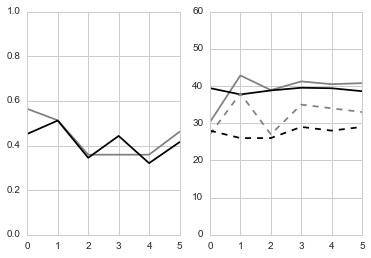

In [491]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,60)

plt.show()

In [ ]:
llh = {pid: 0 for pid in range(6)}
for i, row in df.iterrows():
    probid = row['probid']
    choice = row['choice']
    cp = row['cp']
    if choice == 0:
        llh[probid] += np.log(pfix(1 - cp))
    else:
        llh[probid] += np.log(pfix(cp))

In [ ]:
llh

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
plt.show()

In [ ]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot(df.groupby('probid').apply(lambda d: d.cp.mean()).values)
ax.set_ylim(0,1)
plt.show()

### CHASE + geom

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH2'
OUTDIR = 'process_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_stop_geom': P_STOP_GEOM['HPKH2']}

PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [493]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,1316.584042,5,234,2660.444689,0.000433,0.833131,1.167528,0.761687,0.655597


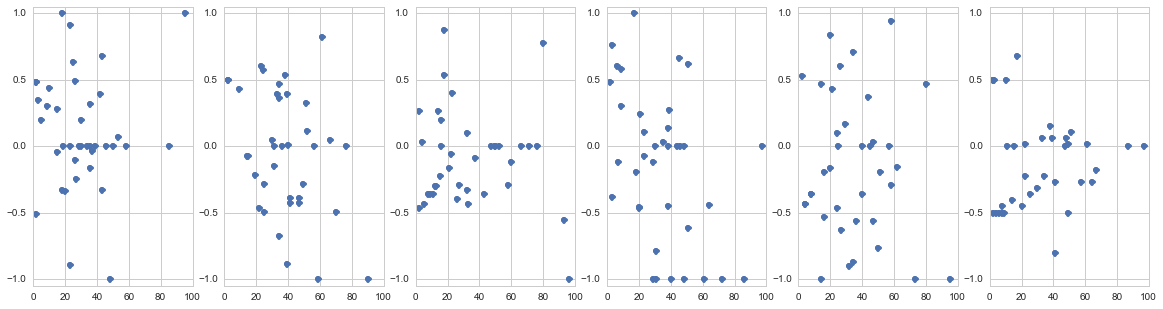

In [483]:
pred = {}
arr = []
for d in HPKH2_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,100)
plt.show()

In [498]:
for pid in range(6):
    print pid
    print problems[pid]

0
[[[ 3.   1. ]
  [ 0.   0. ]]

 [[ 4.   0.8]
  [ 0.   0.2]]]
1
[[[ 3.    0.25]
  [ 0.    0.75]]

 [[ 4.    0.2 ]
  [ 0.    0.8 ]]]
2
[[[-32.    0.1]
  [  0.    0.9]]

 [[ -3.    1. ]
  [  0.    0. ]]]
3
[[[-4.   0.8]
  [ 0.   0.2]]

 [[-3.   1. ]
  [ 0.   0. ]]]
4
[[[  3.    1. ]
  [  0.    0. ]]

 [[ 32.    0.1]
  [  0.    0.9]]]
5
[[[  3.00000000e+00   2.50000000e-01]
  [  0.00000000e+00   7.50000000e-01]]

 [[  3.20000000e+01   2.50000000e-02]
  [  0.00000000e+00   9.75000000e-01]]]


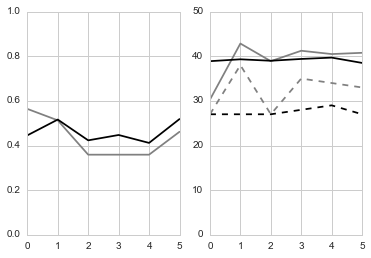

In [495]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'p_switch': P_SWITCH['HPKH2'],
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)
    
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,50)

plt.show()

In [ ]:
llh = {pid: 0 for pid in range(6)}
for i, row in df.iterrows():
    probid = row['probid']
    choice = row['choice']
    cp = row['cp']
    if choice == 0:
        llh[probid] += np.log(pfix(1 - cp))
    else:
        llh[probid] += np.log(pfix(cp))

In [ ]:
llh

In [ ]:
{0: -26.994788602372655,
 1: -22.985235037285271,
 2: -16.927245225174545,
 3: -27.251149138644049,
 4: -26.746905508212905,
 5: -19.132769547444727}

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
plt.show()

In [ ]:
lm = sns.lmplot(x="samplesize", y="choice", row="probid",
                data=df, logistic=False, y_jitter=.03)
for ax in lm.axes.ravel():
    ax.set_ylim(-.05,1.05)
    ax.set_xlim(0,100)

In [ ]:
lm = sns.lmplot(x="cp", y="choice", row="probid",
                data=df, logistic=False, y_jitter=.03)
for ax in lm.axes.ravel():
    ax.set_ylim(-.05,1.05)
    ax.set_xlim(-.05,1.05)

### CHASE (optional stopping)

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH2'
OUTDIR = 'process_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_switch': .1}

PARSETS = [#['theta', 'tau', 'pow_gain'],
           #['theta', 'tau', 'p_fixed', 'prelec_gamma', 'prelec_elevation'],
            ['theta', 'pow_gain', 'prelec_gamma', 'prelec_elevation']
           #['theta', 'tau', 'prelec_gamma', 'prelec_elevation', 'prelec_gamma_loss', 'prelec_elevation_loss', 'pow_gain']
          ]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='indifferent')
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [ ]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_switch': .1,
            #'phi': results.loc[0]['phi'],
            #'p_fixed': results.loc[0]['p_fixed'],
            #'p_stop_geom': results.loc[0]['p_stop_geom'],
            #'prelec_gamma': results.loc[0]['prelec_gamma'],
            #'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)
    
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot([pred[pid]['p_resp'][1] for pid in problems])
ax.set_ylim(0,1)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems])
ax.plot([pred[pid]['samplesize'].mean() for pid in problems])
ax.set_ylim(0,50)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], color='black')
ax.set_ylim(0,40)
plt.show()

In [ ]:
pred[0]['samplesize']

In [ ]:
fig, axi = plt.subplots(2, 6, figsize=(15,8))

for pid in range(6):
    sns.distplot(data[data.problem==pid].samplesize.values, kde=False, ax=axi[1][pid])
    sns.distplot(pred[pid]['samplesize'], kde=False, ax=axi[0][pid], color='gray')
    
for i in range(2):
    for j in range(6):
        axi[i][j].set_xlim(0,200)

In [ ]:
# show the fitting results for the model with the lowest BIC
fitting = {p: PARS[p] for p in PARSETS[0]}
print best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)

m = CHASEModel(drift='cpt', startdist='indifferent')
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)

# Recovery

In [ ]:
from cogmod import cpt as cptmodel

def fit_chase(problems, data, fit_pars):
        
    FIXED = {'dt': .1}
    N_ITER = 1
    SIM_ID = 'recover_process_data'
    OUTDIR = 'chase_fitresults_recover_process_data'

    fitting = {p: PARS[p] for p in fit_pars}

    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='indifferent',
                   problems=problems)

    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR, quiet=False)
    best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                               fitting = fitting, 
                               outdir=OUTDIR)

    return best, pred


PARS = {'theta': [1, 20],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],}

fitting_cpt = {'s': [0, np.inf, 1.],
               'prelec_gamma': [0, 10, 1.]}

def predicted_samplesize(pred):
    cp = pred['p_resp'][1]
    ss = pred['p_stop_cond'][:,1]*cp + pred['p_stop_cond'][:,0]*(1-cp)
    ss = ss/float(ss.sum())
    return np.array(ss)

def observed_samplesize(data):
    bc = np.bincount(data.samplesize)
    return bc/float(bc.sum())

def predicted_cp(pred):
    cp = pred['p_resp'][1]
    return cp

def observed_cp(data):
    return data.choice.mean()

In [ ]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}
#problems = {i: arr[i].reshape((2,2,2)) for i in range(1)}
#problems = [arr[i].reshape((2,2,2)) for i in range(len(arr))]

In [ ]:
with open('/Users/markant/code/chase/chase/paper/glockner_exp3_problems.pkl', 'r') as f:
    glockner_exp3_problems = pickle.load(f)

problems = {}
for p in glockner_exp3_problems:
    if np.sum(glockner_exp3_problems[p][:,:,0].ravel() < 0)==0:
        if np.random.random() < .05:
            problems[p] = glockner_exp3_problems[p]

In [ ]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)